<a href="https://colab.research.google.com/github/pranavi2013/AIML_2024/blob/main/CV_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantdisease


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array

In [3]:
%matplotlib inline

In [4]:
path = kagglehub.dataset_download("emmarex/plantdisease")
print("Dataset downloaded to:", path)

Dataset downloaded to: /kaggle/input/plantdisease


In [5]:
dataset_path = os.path.join(path, 'PlantVillage')

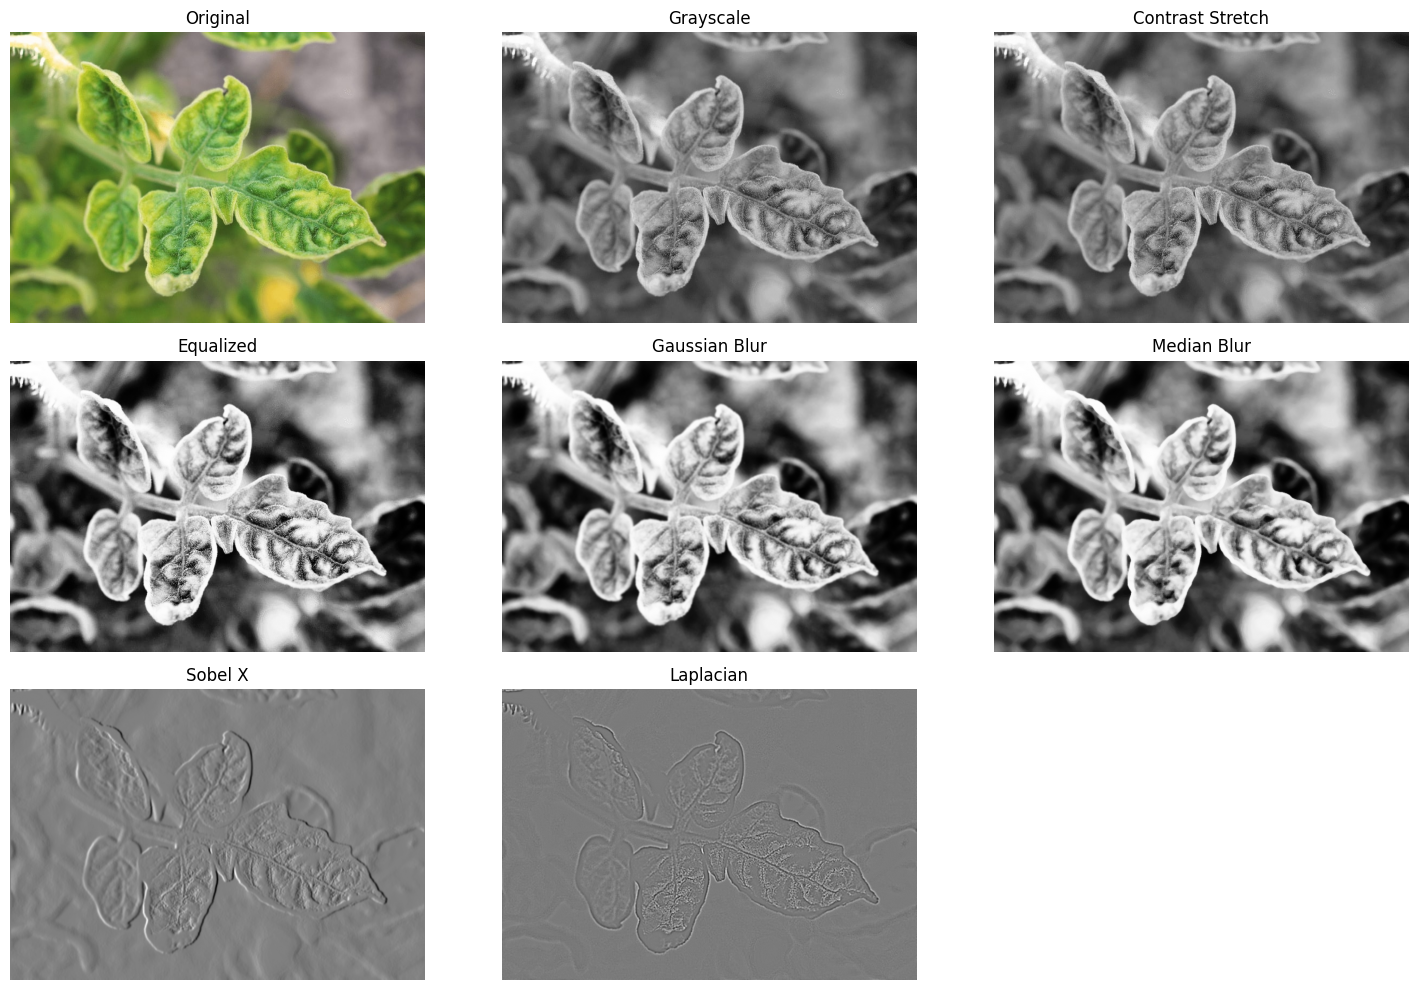

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Example image path
image_path = '/content/photo.jpg'
# Read image
img = cv2.imread(image_path)

# 1. Grayscale Conversion
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Contrast Stretching
# Compute minimum and maximum
gmin, gmax = np.min(gray), np.max(gray)
# Stretch
contrast_stretched = ((gray - gmin) / (gmax - gmin) * 255).astype(np.uint8)

# 3. Histogram Equalization
equalized = cv2.equalizeHist(gray)

# 5. Noise Reduction
gaussian = cv2.GaussianBlur(equalized, (5, 5), 0)
median = cv2.medianBlur(equalized, 5)

# 6. Edge Enhancement
sobelx = cv2.Sobel(gaussian, cv2.CV_64F, 1, 0, ksize=3)
laplacian = cv2.Laplacian(gaussian, cv2.CV_64F)

# Display results
titles = ['Original', 'Grayscale', 'Contrast Stretch', 'Equalized', 'Gaussian Blur', 'Median Blur', 'Sobel X', 'Laplacian']
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB), gray, contrast_stretched, equalized,  gaussian, median, sobelx, laplacian]

plt.figure(figsize=(15, 10))
for i, (title, image) in enumerate(zip(titles, images), 1):
    plt.subplot(3, 3, i)
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()

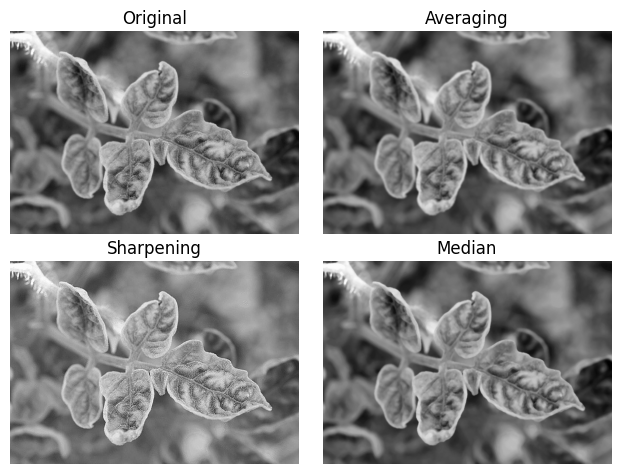

In [10]:
# Spatial Filtering: Smoothing, Sharpening, and Median Filter
# Read and grayscale conversion
img = cv2.imread(image_path, 0)

# Smoothing (Averaging)
kernel = np.ones((5,5), np.float32) / 25
avg = cv2.filter2D(img, -1, kernel)

# Sharpening
kernel_sharp = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
sharp = cv2.filter2D(img, -1, kernel_sharp)

# Median Filtering
median = cv2.medianBlur(img, 5)

# Display
titles = ['Original', 'Averaging', 'Sharpening', 'Median']
images = [img, avg, sharp, median]
for i, (t, im) in enumerate(zip(titles, images),1):
    plt.subplot(2,2,i); plt.imshow(im, cmap='gray'); plt.title(t); plt.axis('off')
plt.tight_layout(); plt.show()

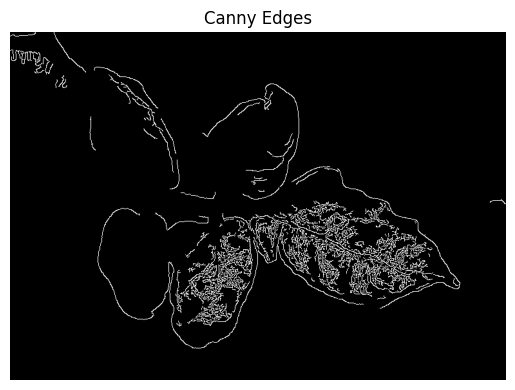

In [11]:
gray = cv2.imread(image_path, 0)
edges = cv2.Canny(gray, 100, 200)
plt.imshow(edges, cmap='gray'); plt.title('Canny Edges'); plt.axis('off'); plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.1,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=25,
    validation_split=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)

train_dataset = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)

valid_dataset = valid_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [ ]:
class_labels = list(train_dataset.class_indices.keys())
class_labels

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(768, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dense(len(class_labels), activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoint.keras', monitor='val_loss', save_best_only=True)


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=25,
    callbacks=[earlystopping, learning_rate, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 353s 657ms/step - accuracy: 0.5742 - loss: 3.2998 - val_accuracy: 0.8202 - val_loss: 0.5698 - learning_rate: 0.0010
Epoch 2/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 218s 421ms/step - accuracy: 0.8019 - loss: 0.6277 - val_accuracy: 0.8559 - val_loss: 0.4534 - learning_rate: 0.0010
Epoch 3/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 214s 414ms/step - accuracy: 0.8459 - loss: 0.4844 - val_accuracy: 0.8520 - val_loss: 0.4465 - learning_rate: 0.0010
Epoch 4/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 224s 433ms/step - accuracy: 0.8604 - loss: 0.4293 - val_accuracy: 0.9049 - val_loss: 0.3051 - learning_rate: 0.0010
Epoch 5/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 208s 402ms/step - accuracy: 0.8756 - loss: 0.3936 - val_accuracy: 0.8724 - val_loss: 0.3871 - learning_rate: 0.0010
Epoch 6/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 218s 421ms/step - accuracy: 0.8872 - loss: 0.3589 - val_accuracy: 0.9073 - val_loss: 0.3003 - learning_rate: 0.0010
Epoch 7/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 207s 400ms/step - accura

In [ ]:
model.save('/content/plant_disease_model.h5')
print("Model saved as plant_disease_model.h5")


Model saved as plant_disease_model.h5


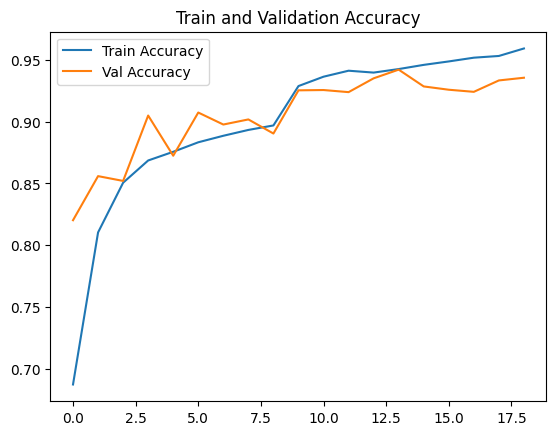

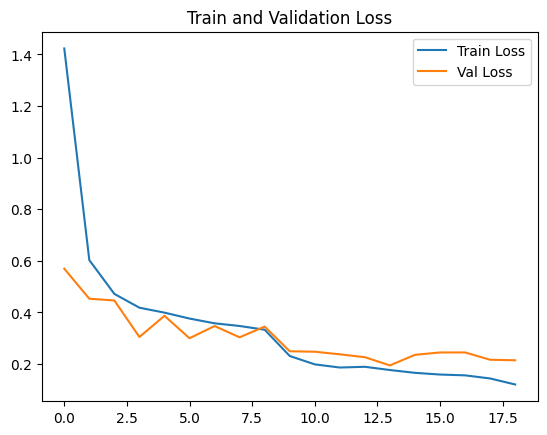

In [ ]:
plt.figure()
plt.title('Train and Validation Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.title('Train and Validation Loss')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


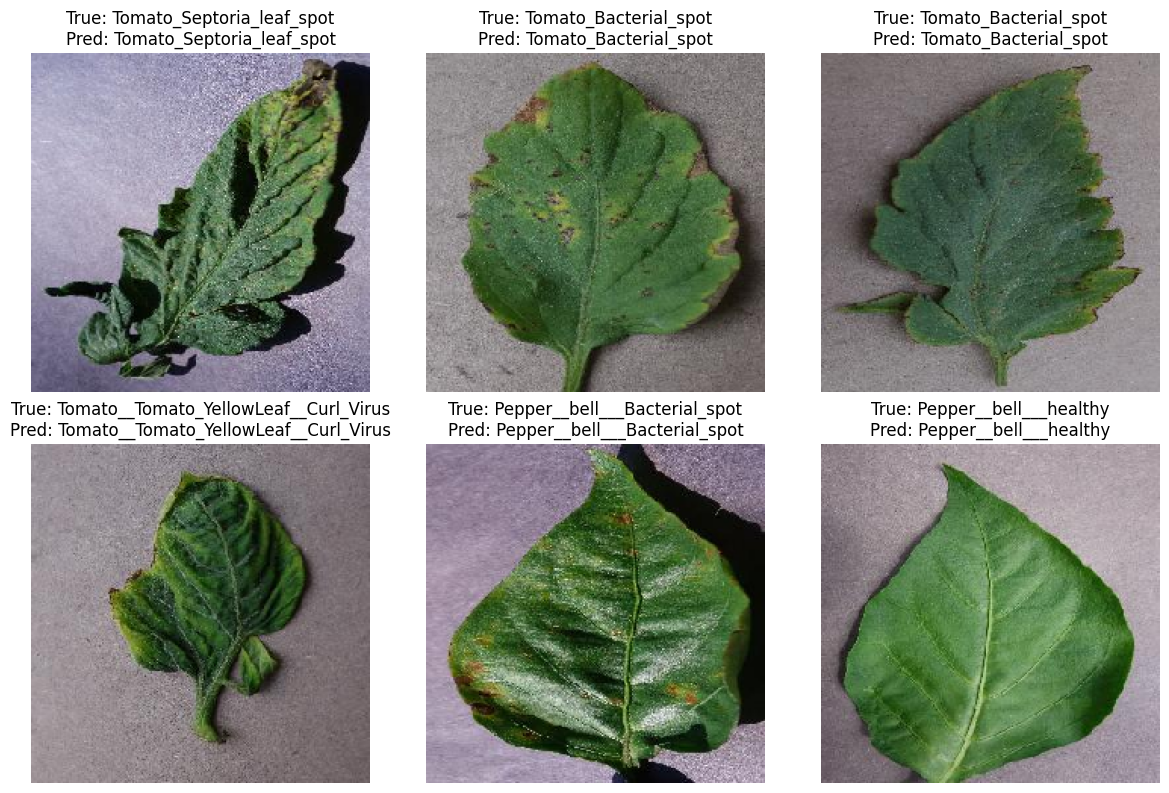

In [ ]:
images, labels = next(valid_dataset)

plt.figure(figsize=(12, 8))
for i in range(6):
    img = images[i]
    label = np.argmax(labels[i])
    image_array = tf.expand_dims(img, axis=0)
    pred = model.predict(image_array)[0].argmax()

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f'True: {class_labels[label]}\nPred: {class_labels[pred]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Choose image input method:
1. Upload image from system
2. Take photo using webcam
3. Enter image path manually
Enter your choice (1/2/3): 1


Saving photo.jpg to photo.jpg
Uploaded file: photo.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


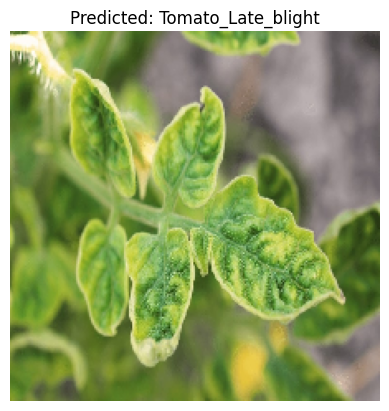

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files
from IPython.display import display
from PIL import Image
import cv2

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

def take_photo(filename='photo.jpg'):
    from IPython.display import Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    # Capture using JavaScript
    display(Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = '📸 Take Photo';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            div.appendChild(video);
            document.body.appendChild(div);

            const stream = await navigator.mediaDevices.getUserMedia({ video: true });

            video.srcObject = stream;
            await video.play();

            // Resize video
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();

            const dataUrl = canvas.toDataURL('image/jpeg');
            return dataUrl;
        }
        takePhoto();
    '''))

    data = eval_js("takePhoto()")
    binary = b64decode(data.split(',')[1])

    with open(filename, 'wb') as f:
        f.write(binary)

    return filename

# Ask user how they want to input the image
print("Choose image input method:")
print("1. Upload image from system")
print("2. Take photo using webcam")
print("3. Enter image path manually")

choice = input("Enter your choice (1/2/3): ")

if choice == '1':
    uploaded = files.upload()
    for fn in uploaded.keys():
        print(f"Uploaded file: {fn}")
        predict_image(fn)

elif choice == '2':
    photo_path = take_photo()
    print(f"Photo saved as: {photo_path}")
    predict_image(photo_path)

elif choice == '3':
    img_path = input("Enter full image path (e.g., /content/image.jpg): ")
    if os.path.exists(img_path):
        predict_image(img_path)
    else:
        print("❌ File not found. Please check the path.")
else:
    print("Invalid choice. Please enter 1, 2, or 3.")


In [ ]:
!pip install gradio --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.9 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the model from your saved path
model = tf.keras.models.load_model("/content/plant_disease_model.h5")

# List of class labels used during training — update this if needed
class_labels = list(train_dataset.class_indices.keys())

# Prediction function
def predict(img):
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array)[0]
    predicted_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_index]
    confidence = round(100 * np.max(predictions), 2)

    return f"🌿 Predicted: {predicted_class} ({confidence}%)"

# Gradio Interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="🌱 Plant Disease Detector",
    description="Upload a leaf image to identify the disease (or check if it's healthy)."
)

# Launch with public shareable link
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://12f9a4ee143b508799.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
'''website:https://huggingface.co/spaces/pranavireddy/plant-disease-detector'''